## 4.1.1 ARIMAモデルの復習

前チャプターで説明したARIMAモデルについて、もう一度復習してみましょう。
ARIMAモデルは、以前の値に影響されるモデルであり、直前p個の値と相関をもつようなARモデルAR(p)AR(p)と、以前の誤差に影響されるモデルで直前q個の値の影響を受けるようなMAモデルMA(q)MA(q)を合成したARMA(p, q)ARMA(p,q)を、d時点前の階差系列に適応したものでした。 
そして、 SARIMAモデル とはARIMAモデルをさらに季節周期を持つ時系列データにも拡張できるようにしたモデルです。
SARIMAモデルは(p, d, q)のパラメーターに加えて(sp, sd, sq, s)というパラメーターも持ちます。



## 4.1.2 sp,sd,sqとは

sp,sd,sq はそれぞれ 季節性自己相関 、 季節性導出 、 季節性移動平均 といいます。
ところで、ARIMA(p, d, q) モデルの

・ p は 自己相関度 といい、 モデルが直前 p 個の値を用いて予測されるのか を

・ d は 誘導 といい、 時系列データを定常にするために d 次の階差が必要だったこと を

・ q は 移動平均 といい、 モデルが直前 q 個の値に影響を受けること を

表しているのでした。
sp,sd,sq も基本的な意味は変わりません。しかし、 sp,sd,sq の場合は、現在のデータはひとつ以上の季節期間を経た過去のデータに影響されます。
例えば12ヶ月周期の季節変動を持つデータの場合、 s のパラメーターは周期を表すため、 s=12 となります。
sq=1 ならちょうど12ヶ月(1周期前)のデータ, sq=2 なら12ヶ月前のデータと24ヶ月前のデータの影響をモデルが受けることを表します。
分かりにくければ単純に q を sq に置き換えてみてください。


## 4.1.3 パラメーターの決定

PythonにはSARIMAモデルのパラメーター、(p, d, q) (sp, sd, sq, s)を自動で最も適切にしてくれる機能はありません、そのため 情報量規準 (今回の場合は BIC(ベイズ情報量基準) )によってどの値が最も適切なのか調べるプログラムを書かなければなりません。

情報規準量については今回は深く触れませんが、BICの場合は この値が低ければ低いほどパラメーターの値は適切である と理解しておいてください。 
しかしながら、そのようなコードを書くということ自体は本テーマである時系列分析の趣旨と逸れてしまうため、今回はこちらでそのコードをご用意させていただきました。 時系列データ:DATA, パラメータs(周期):sを入力すると、最も良いパラメーターとそのBICを出力します。


In [ ]:

def selectparameter(DATA,s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    parameters = []
    BICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(DATA,
                                            order=param,
                seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.bic])
                BICs = np.append(y,results.bic)
            except:
                continue
    return print(parameters[np.argmin(BICs)])



関数の内容を詳しく言うと各パラメーターがそれぞれ、0,1(今回は単純のためパラーメーターの上限を1までとしました)の場合についてのSARIMAモデルのBICを計算し、最もBICが小さくなった場合を表示するようになっている。

ただし、パラメーター ss に関しては事前に時系列データや次に説明する偏自己相関の可視化を行うことによって調べておく。

In [8]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

# データの読み込みと整理
sales_sparkring = pd.read_csv(filepath_or_buffer = "https://aidemyexcontentsdata.blob.core.windows.net/data/5060_tsa/monthly-australian-wine-sales-th-sparkling.csv")
index = pd.date_range("1980-01-31","1995-07-31",freq="M")
sales_sparkring.index=index
del sales_sparkring["Month"]

# 1年間分のデータにしています
sales_sparkring = sales_sparkring[:12]

# 関数の定義
def selectparameter(DATA,s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    parameters = []
    BICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(DATA,
                                            order=param,
                                            seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.bic])
                BICs = np.append(BICs,results.bic)
            except:
                continue
    return parameters[np.argmin(BICs)]

# 周期を埋めて最適なパラメーターを求めてください
selectparameter(sales_sparkring,12)

[(1, 1, 0), (0, 0, 0, 12), 179.05767872321437]

## 4.1.4 自己相関係数・偏自己相関係数とその可視化


自己相関とは自己の過去のデータとの相関のことでした。時系列データの分析にはもう一つ、 偏自己相関 という値が重要になります。

k次自己相関といえば y_tと y_{t-k}の相関を表しますが、k次偏自己相関というと y_t と y_{t-k} の間のデータ、
すなわち y_{t-1} から y_{t-k+1} の影響を取り除いた相関になります。

具体的に説明します。7日間差の自己相関係数を求めたとします。しかし、ある日のデータが前日のデータと相関があった場合、7日前→6日前→5日前......1日前→今日とデータを通して相関している可能性があります。この間の影響を取り除いて相関を求めたものが偏自己相関と呼ばれます。 Pythonを用いて自己相関係数と偏自己相関係数を可視化してみましょう。 一般的に月ごとのデータに季節性がある場合にはその周期は12になります。

自己相関係数のグラフは
sm.graphics.tsa.plot_acf(DATA)

偏自己相関のグラフは 
sm.graphics.tsa.plot_pacf(DATA)

で出力できる。


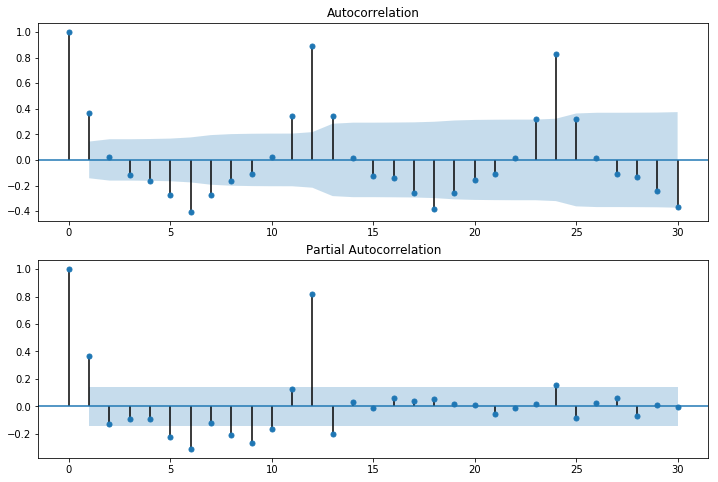

In [9]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import datetime

# データの読み込みと整理
sales_sparkring = pd.read_csv(filepath_or_buffer = "https://aidemyexcontentsdata.blob.core.windows.net/data/5060_tsa/monthly-australian-wine-sales-th-sparkling.csv")
index = pd.date_range("1980-01-31", "1995-07-31", freq="M")
sales_sparkring.index=index
del sales_sparkring["Month"]
# 自己相関・偏自己相関の可視化
fig=plt.figure(figsize=(12, 8))
# 自己相関係数のグラフを出力します
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales_sparkring, lags=30, ax=ax1)
# 偏自己相関係数のグラフを出力します
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales_sparkring, lags=30, ax=ax2)

plt.plot()
plt.show()
# なにも記入せず実行してください

## 4.2.1 モデルの構築

ここで一度SARIMAモデルを用いた時系列データの分析手順をまとめてみましょう。

1.データの読み込み

2.データの整理

3.データの可視化

4.データの周期の把握 (パラメーターsの決定)

5.s以外のパラメーターの決定

6.モデルの構築

7.データとの予測とその可視化

という流れで行われます。いよいよ最後にこの節ではモデルの構築から予測までを学びます。
前セクションの方法によって、最適な(p,d,q),(sp,sd,sq,s)(p,d,q),(sp,sd,sq,s)が分かったらいよいよモデルを構築します。
モデルの構築にはsm.tsa.statespace.SARIMAX(DATA,order=(p, d, q),seasonal_order=(sp, sd, sq, s).fit()を用います。

パラメーター(p, d, q), (sp.sd, sq, s)は(0, 0, 0), (0, 1, 1, 12)とします。

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import datetime
import numpy as np

# データの読み込みと整理
sales_sparkring = pd.read_csv(filepath_or_buffer = "https://aidemyexcontentsdata.blob.core.windows.net/data/5060_tsa/monthly-australian-wine-sales-th-sparkling.csv")
index = pd.date_range("1980-01-31", "1995-07-31", freq="M")
sales_sparkring.index=index
del sales_sparkring["Month"]

# モデルの当てはめ
SARIMA_sparkring_sales = sm.tsa.statespace.SARIMAX(sales_sparkring,order=(0, 0, 0),seasonal_order=(0, 1, 1, 12)).fit()

                                                   
#構築したSARIMAモデルのBICを出力します
print(SARIMA_sparkring_sales.bic)

2585.27608421


## 4.2.2 予測の実行と予測データの可視化

モデルの予測データを得るのは簡単でモデル名.predict("予測開始時","予測終了時")を用います。ただし、"予測開始時"はもとの時系列データにある時間でなければなりません。例えば、今回使用したスパークリングワインの売上データでは1995-07-31以前である必要があります。


     Month  sales
0  1980-01   1686
1  1980-02   1591
2  1980-03   2304
3  1980-04   1712
4  1980-05   1471
       Month  sales
182  1995-03   1897
183  1995-04   1862
184  1995-05   1670
185  1995-06   1688
186  1995-07   2031


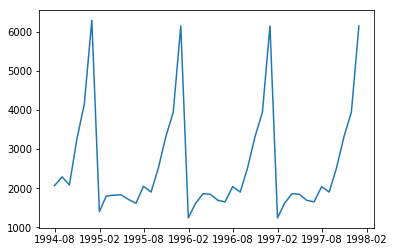

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import datetime
import numpy as np

# データの読み込みと整理
sales_sparkring = pd.read_csv(filepath_or_buffer = "https://aidemyexcontentsdata.blob.core.windows.net/data/5060_tsa/monthly-australian-wine-sales-th-sparkling.csv")
print(sales_sparkring.head())
print(sales_sparkring.tail())
index = pd.date_range("1980-01-31", "1995-07-31", freq="M")
sales_sparkring.index=index
del sales_sparkring["Month"]

# モデルの当てはめ
SARIMA_sparkring_sales = sm.tsa.statespace.SARIMAX(sales_sparkring,order=(0, 0, 0),seasonal_order=(0, 1, 1, 12)).fit()

# predに予測データを代入する
# pred = SARIMA_sparkring_sales.predict("予測開始時", "予測終了時")
pred = SARIMA_sparkring_sales.predict("1994-07-31", "1997-12-31")

# preadデータの可視化
plt.plot(pred)
plt.show()


## 4.2.3 実際データと予測データの比較

次は予測データだけを出力するのではなく、もとの時系列データと予測データを同時に出力して比べてみましょう。
シャンプーの売上データと、そのSARIMAモデルによる予測データのグラフを同時に出力して比べてください。
予測期間は1994-07-31から1997-12-31までとしてください。また、予測データのグラフは赤で表示させてください。


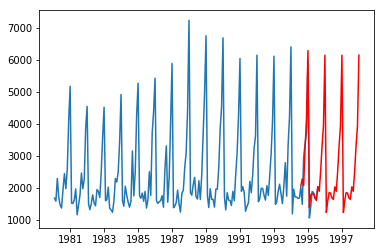

In [18]:

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import datetime
import numpy as np

# データの読み込みと整理
sales_sparkring = pd.read_csv(filepath_or_buffer = "https://aidemyexcontentsdata.blob.core.windows.net/data/5060_tsa/monthly-australian-wine-sales-th-sparkling.csv")
index = pd.date_range("1980-01-31", "1995-07-31", freq="M")
sales_sparkring.index=index
del sales_sparkring["Month"]

# モデルの当てはめ
SARIMA_sparkring_sales = sm.tsa.statespace.SARIMAX(sales_sparkring,order=(0, 0, 0),seasonal_order=(0, 1, 1, 12)).fit()

# predに予測データを代入する
pred = SARIMA_sparkring_sales.predict("1994-7-31", "1997-12-31")

# preadデータともとの時系列データの可視化
plt.plot(sales_sparkring)
plt.plot(pred, color='r')
plt.show()